<h1>Minimum Distance Analysis for Field Emission from a Ring-Shaped Emitter

<h3>Import

In [19]:
# Math
import numpy as np
import math as m
# Data
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

<h4>Functions

In [20]:
def ave_min(data):
    '''Find the average minimum angle from each point to its nearest neighbour'''
    # Calculate the distance between each point
    min_dist = 0
    for i in range(len(data)):
        min_dist += data.iloc[i]['min_dist']
    ave_min_dist = min_dist/len(data)
    return ave_min_dist

<h4>Fetch data

In [21]:
simulations = {
    10000: {'time_start': 500, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    11000: {'time_start': 400, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    12000: {'time_start': 300, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    # 13000: {'time_start': 300, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    14000: {'time_start': 300, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    15000: {'time_start': 300, 'time_end': 1000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0}
}
elecbase = f'/out/elec-'
elec_dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('min_dist', np.float64)])

fieldbase = '/out/field.dt'

for voltage,simulation in simulations.items():
    field_filename = f'./V{voltage}{fieldbase}'
    df_field = pd.read_csv(filepath_or_buffer=field_filename, index_col = 1,delim_whitespace=True, \
                    header=None, names=['step', 'b', 'c', 'field', 'e', 'f', 'g', 'h'])
    field = df_field['field'].to_numpy()
    
    simulations[voltage]['E0'] = voltage/simulation['distance']

    time_steps = np.arange(simulation['time_start'], simulation['time_end']+1, simulation['time_step'], dtype=int)
    for time_step in time_steps:
        elec_filename = f'./V{voltage}{elecbase}{time_step}.bin'

        data_mem_abs = np.memmap(elec_filename, dtype=elec_dt_abs_type, mode='r', order='F')
        elec_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)
        elec_slice_data = elec_data[(elec_data['z'] >= simulation['d_min']) & (elec_data['z'] <= simulation['d_max'])]
    
        simulations[voltage]['E'] -= field[time_step-1]
        try:
            simulations[voltage]['ave_min_dist'] += ave_min(elec_slice_data)
        except ZeroDivisionError:
            print(time_step)

    simulations[voltage]['E'] /= len(time_steps)
    simulations[voltage]['ave_min_dist'] /= len(time_steps)


<h4>Minimum distance as a function of field

Slope: -2.95


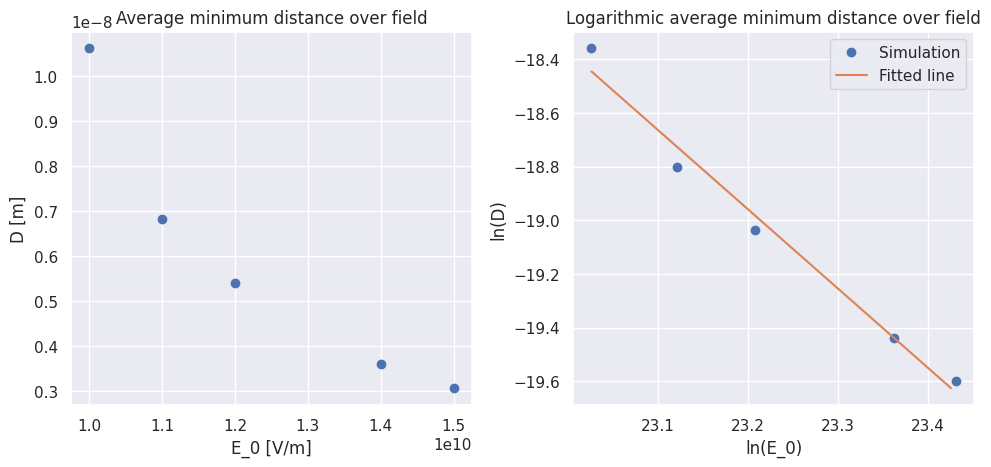

In [22]:
fig = plt.figure(figsize=(10,5))

E = []
D = []
for voltage,simulation in simulations.items():
    E.append(simulation['E0'])
    D.append(simulation['ave_min_dist'])

ax1 = fig.add_subplot(121)
ax1.plot(E, D,'o', label='Simulation')
ax1.set_xlabel('E_0 [V/m]')
ax1.set_ylabel('D [m]')
ax1.set_title('Average minimum distance over field')

ax2 = fig.add_subplot(122)
log_E = [np.log(e) for e in E]
log_D = [np.log(d) for d in D]
slope, intercept = np.polyfit(log_E, log_D, 1)
log_E_fit = np.arange(min(log_E), max(log_E), 0.1)
log_D_fit = slope*log_E_fit + intercept
print(f'Slope: {slope:.2f}')

ax2.plot(log_E, log_D, 'o', label='Simulation')
ax2.plot(log_E_fit, log_D_fit, label=f'Fitted line')
ax2.set_xlabel('ln(E_0)')
ax2.set_ylabel('ln(D)')
ax2.legend()
ax2.set_title('Logarithmic average minimum distance over field')

plt.tight_layout()
plt.show()

Slope: -1.09


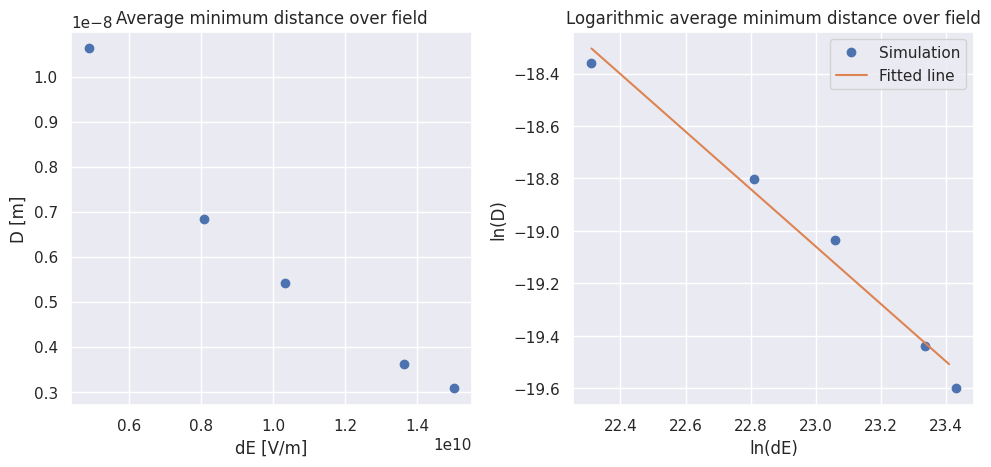

In [23]:
fig = plt.figure(figsize=(10,5))

E = []
D = []
for voltage,simulation in simulations.items():
    E.append(simulation['E0']-simulation['E'])
    D.append(simulation['ave_min_dist'])

ax1 = fig.add_subplot(121)
ax1.plot(E, D,'o', label='Simulation')
ax1.set_xlabel('dE [V/m]')
ax1.set_ylabel('D [m]')
ax1.set_title('Average minimum distance over field')

ax2 = fig.add_subplot(122)
log_E = [np.log(e) for e in E]
log_D = [np.log(d) for d in D]
slope, intercept = np.polyfit(log_E, log_D, 1)
log_E_fit = np.arange(min(log_E), max(log_E), 0.1)
log_D_fit = slope*log_E_fit + intercept
print(f'Slope: {slope:.2f}')

ax2.plot(log_E, log_D, 'o', label='Simulation')
ax2.plot(log_E_fit, log_D_fit, label=f'Fitted line')
ax2.set_xlabel('ln(dE)')
ax2.set_ylabel('ln(D)')
ax2.legend()
ax2.set_title('Logarithmic average minimum distance over field')

plt.tight_layout()
plt.show()

Slope: 0.04


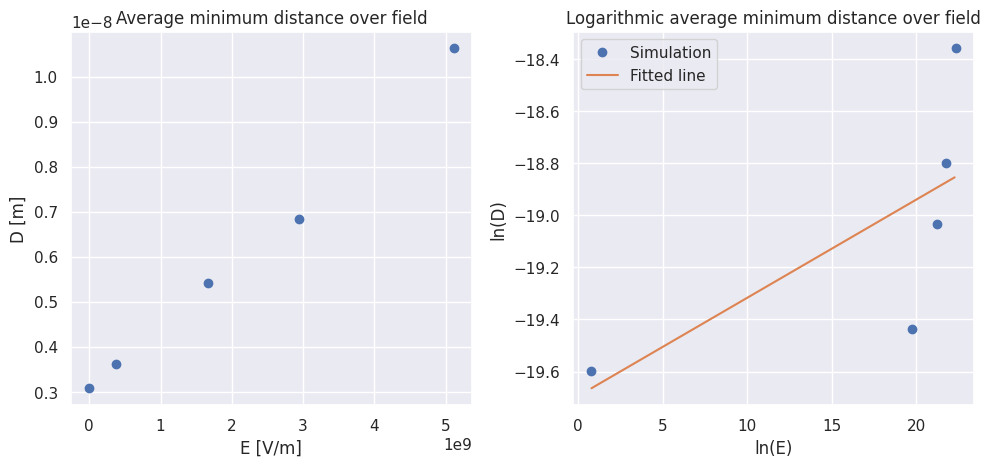

In [24]:
fig = plt.figure(figsize=(10,5))

E = []
D = []
for voltage,simulation in simulations.items():
    E.append(simulation['E'])
    D.append(simulation['ave_min_dist'])

ax1 = fig.add_subplot(121)
ax1.plot(E, D,'o', label='Simulation')
ax1.set_xlabel('E [V/m]')
ax1.set_ylabel('D [m]')
ax1.set_title('Average minimum distance over field')

ax2 = fig.add_subplot(122)
log_E = [np.log(e) for e in E]
log_D = [np.log(d) for d in D]
slope, intercept = np.polyfit(log_E, log_D, 1)
log_E_fit = np.arange(min(log_E), max(log_E), 0.1)
log_D_fit = slope*log_E_fit + intercept
print(f'Slope: {slope:.2f}')

ax2.plot(log_E, log_D, 'o', label='Simulation')
ax2.plot(log_E_fit, log_D_fit, label=f'Fitted line')
ax2.set_xlabel('ln(E)')
ax2.set_ylabel('ln(D)')
ax2.legend()
ax2.set_title('Logarithmic average minimum distance over field')

plt.tight_layout()
plt.show()